In [15]:
import pandas as pd
from datetime import datetime as DateTime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Configurando los estílos de los gráficos
plt.ioff()
sns.set_context('talk')
sns.set_style("whitegrid")

## Adquisición de Datos

In [16]:
df = pd.read_csv('data/defunciones.csv')

In [17]:
df

,FECHA_CORTE,UUID,FECHA_FALLECIMIENTO,EDAD_DECLARADA,SEXO,FECHA_NAC,DEPARTAMENTO,PROVINCIA,DISTRITO
0,20210421,a896d7b53b2cbfc8eda0f9aa8c729391,20200530,69,MASCULINO,19500708.0,LIMA,LIMA,LIMA
1,20210421,924d15c4675d69df98ed4241ea3c30fb,20200530,73,MASCULINO,19470110.0,LIMA,LIMA,SURQUILLO
2,20210421,70fcda332600657b3d53bee933821886,20200530,72,FEMENINO,19480315.0,LIMA,LIMA,SAN MARTIN DE PORRES
3,20210421,d7991580990db8bcc485f6d5cff9a32f,20200530,66,MASCULINO,19540513.0,LIMA,LIMA,JESUS MARIA
4,20210421,ef817f4c2fcfd361401cc98b1ff1267e,20200530,29,MASCULINO,19910203.0,LIMA,LIMA,LIMA
...,...,...,...,...,...,...,...,...,...
58599,20210421,79ff49b6ffcfb59f2a521b7e1f502bbe,20210123,73,MASCULINO,NaN,LIMA,LIMA,CARABAYLLO
58600,20210421,73ba1a36d9c658b9389a2224a488f083,20210123,76,MASCULINO,NaN,LIMA,LIMA,CHACLACAYO
58601,20210421,6ee3ac1895741a9bdfe41b9bf89e7ab4,20210123,55,FEMENINO,NaN,LIMA,LIMA,CHACLACAYO
58602,20210421,9d37b1f7081a0fcec1d41d70e2ffec9b,20210123,87,FEMENINO,NaN,LIMA,LIMA,CHORRILLOS


## Transformación de Datos

### Calculando defunciones por día

In [18]:
gb = df.groupby(by="FECHA_FALLECIMIENTO")

In [19]:
data = []
for i in gb:
    data.append(
        {
            'date': DateTime.strptime(str(i[0]),'%Y%m%d'),
            'count': len(i[1])
        }
    )

daily = pd.DataFrame(data, columns=['date','count'])
daily.head(5)

,date,count
0,2020-03-18,1
1,2020-03-19,3
2,2020-03-20,2
3,2020-03-21,1
4,2020-03-22,2


### Calculando defunciones por semana

In [20]:
data = daily.copy()
data['low'] = data['count'].rolling(7).min()
data['high'] = data['count'].rolling(7).max()

In [21]:
weekly = data.set_index(data['date']).resample('W').agg({'date': 'last','high': 'max', 'low': 'min','count': 'last'}).reset_index(drop=True)[['date','high','low','count']]
weekly.head(5)

,date,high,low,count
0,2020-03-22,NaN,NaN,2
1,2020-03-29,12.0,1.0,12
2,2020-04-05,45.0,1.0,16
3,2020-04-12,67.0,13.0,67
4,2020-04-19,114.0,29.0,114


## Visualización de Datos

In [22]:
PERIOD = 12

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

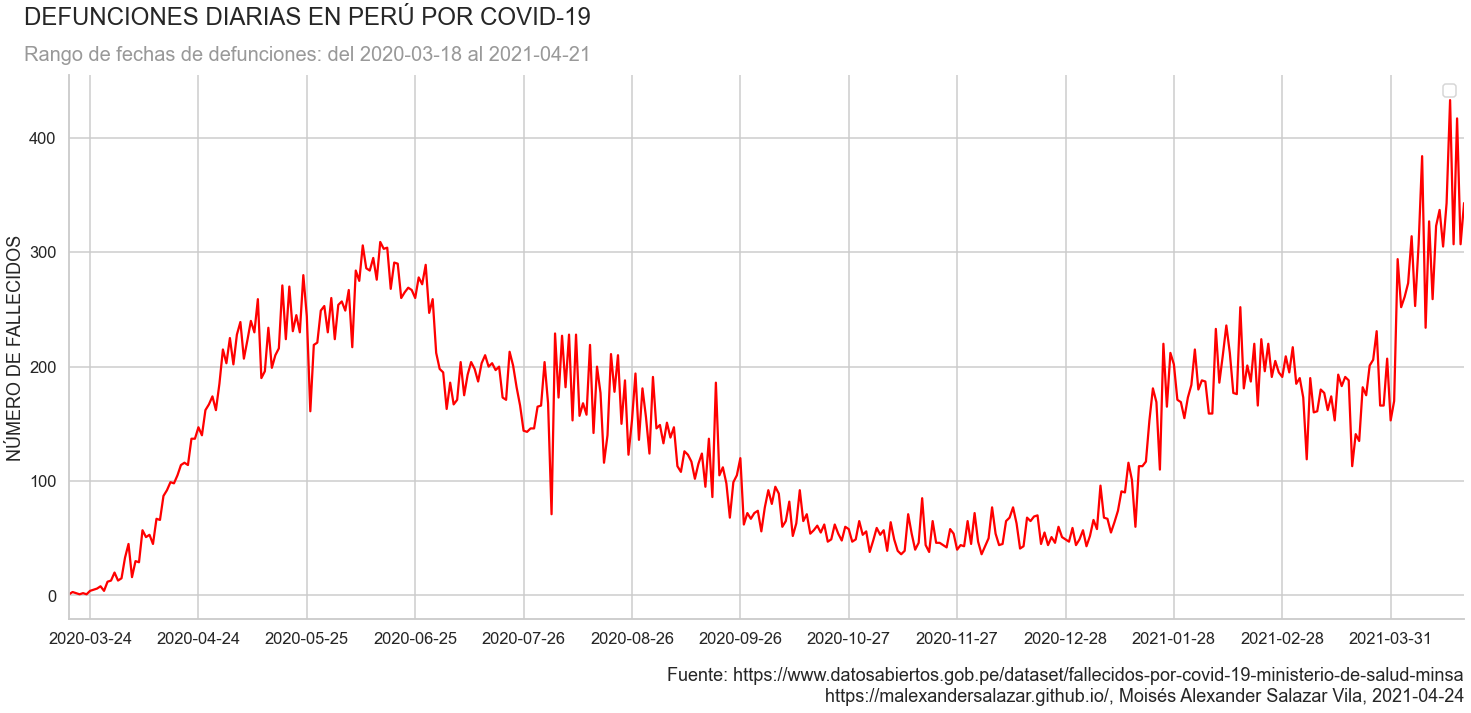

In [23]:
plt.clf()

fig, axs = plt.subplots(figsize=(25,10))
plt.figtext(0.1,0.95, 'DEFUNCIONES DIARIAS EN PERÚ POR COVID-19', ha='left', fontsize=24)
plt.figtext(0.1,0.90, 'Rango de fechas de defunciones: del {} al {}'.format(f'{daily["date"].iat[0]:%Y-%m-%d}',f'{daily["date"].iat[-1]:%Y-%m-%d}'), ha='left', fontsize=20, color='#999')
plt.figtext(0.9,0.01, """Fuente: https://www.datosabiertos.gob.pe/dataset/fallecidos-por-covid-19-ministerio-de-salud-minsa
https://malexandersalazar.github.io/, Moisés Alexander Salazar Vila, """ + f'{DateTime.now():%Y-%m-%d}', ha='right')

formatter = mdates.DateFormatter("%Y-%m-%d")
locator = mdates.DayLocator(interval=31)

axs.xaxis.set_major_formatter(formatter)
axs.xaxis.set_major_locator(locator)

axs.plot(daily['date'], daily['count'], color='r')

axs.set_xlim((daily["date"].iat[0],daily["date"].iat[-1]))
axs.set_ylabel('NÚMERO DE FALLECIDOS')
axs.legend()

sns.despine(left=False, bottom=False)

filename = 'dist/DEFUNCIONES.png'
plt.savefig("../" + filename, bbox_inches='tight')

plt.show()
plt.close(fig)

In [24]:
low_in_period = weekly['low'].rolling(PERIOD).min()
high_in_period = weekly['high'].rolling(PERIOD).max()
percentK = pd.Series((weekly['count'] - low_in_period) / (high_in_period - low_in_period) * 100, name='%K')
percentD = pd.Series(percentK.rolling(3).mean(), name='%D')
percentDn = pd.Series(percentD.rolling(3).mean(), name='%Dn')

<Figure size 432x288 with 0 Axes>

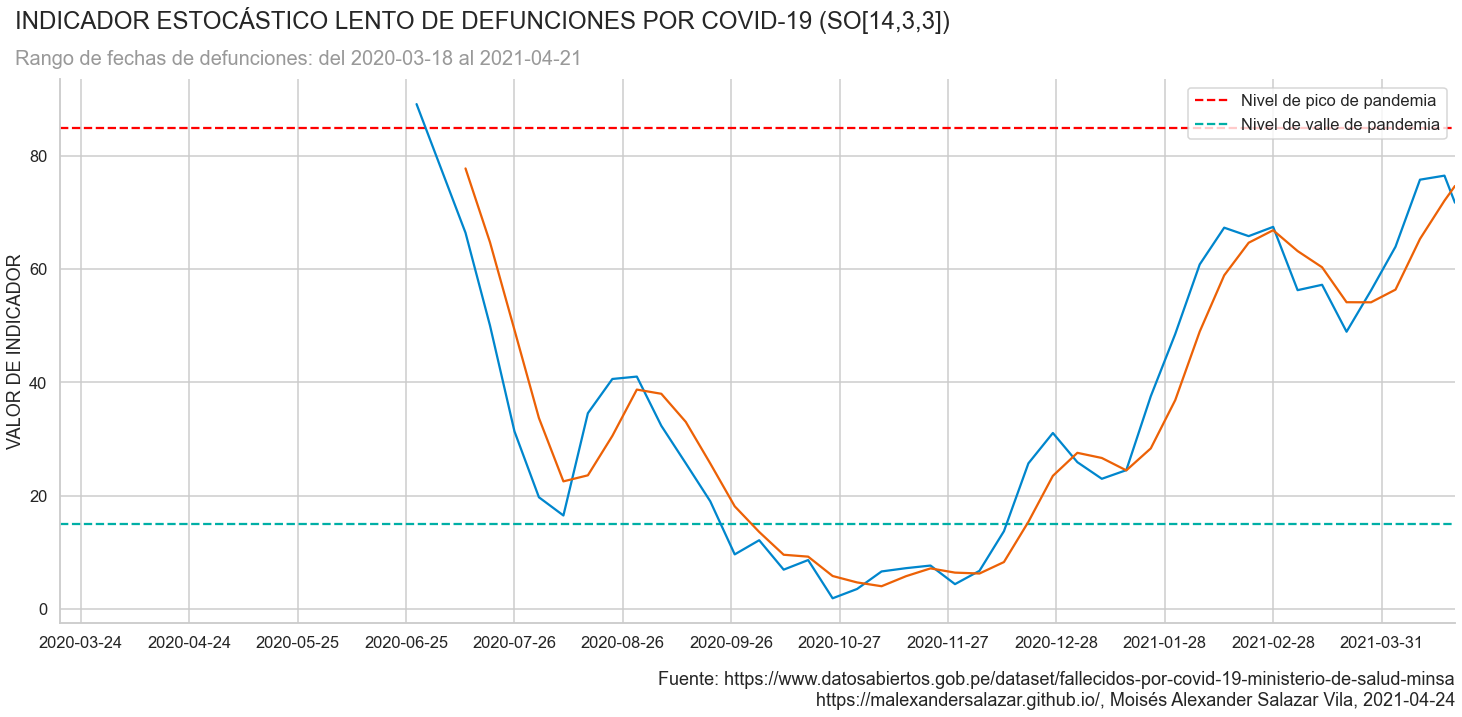

In [25]:
plt.clf()

fig, axs = plt.subplots(figsize=(25,10))
plt.figtext(0.1,0.95, 'INDICADOR ESTOCÁSTICO LENTO DE DEFUNCIONES POR COVID-19 (SO[14,3,3])', ha='left', fontsize=24)
plt.figtext(0.1,0.90, 'Rango de fechas de defunciones: del {} al {}'.format(f'{daily["date"].iat[0]:%Y-%m-%d}',f'{daily["date"].iat[-1]:%Y-%m-%d}'), ha='left', fontsize=20, color='#999')
plt.figtext(0.9,0.01, """Fuente: https://www.datosabiertos.gob.pe/dataset/fallecidos-por-covid-19-ministerio-de-salud-minsa
https://malexandersalazar.github.io/, Moisés Alexander Salazar Vila, """ + f'{DateTime.now():%Y-%m-%d}', ha='right')

formatter = mdates.DateFormatter("%Y-%m-%d")
locator = mdates.DayLocator(interval=31)

axs.xaxis.set_major_formatter(formatter)
axs.xaxis.set_major_locator(locator)

axs.plot(weekly['date'], percentD, color='#0086CD')
axs.plot(weekly['date'], percentDn, color='#EC6106')
axs.hlines(85, daily["date"].iat[0], daily["date"].iat[-1], color='r', linestyles= 'dashed', label='Nivel de pico de pandemia')
axs.hlines(15, daily["date"].iat[0], daily["date"].iat[-1], color='#00AFA6', linestyles= 'dashed', label='Nivel de valle de pandemia')

# axs.set_xlim((weekly["date"].iat[PERIOD],daily["date"].iat[-1]))
axs.set_xlim((daily["date"].iat[0],daily["date"].iat[-1]))
axs.set_ylabel('VALOR DE INDICADOR')
axs.legend()

sns.despine(left=False, bottom=False)

filename = 'dist/SO.png'
plt.savefig("../" + filename, bbox_inches='tight')

plt.show()
plt.close(fig)

In [26]:
daily_delta = daily['count'].diff()
daily_up = daily_delta.clip(lower=0)
daily_down = -1*daily_delta.clip(upper=0)

ema_up = daily_up.ewm(com=26,adjust=False).mean()
ema_down = daily_down.ewm(com=26,adjust=False).mean()
daily_rs = ema_up/ema_down
daily_rsi = 100-(100/(1+daily_rs))

weekly_delta = weekly['count'].diff()
weekly_up = weekly_delta.clip(lower=0)
weekly_down = -1*weekly_delta.clip(upper=0)

ema_up = weekly_up.ewm(com=PERIOD-1,adjust=False).mean()
ema_down = weekly_down.ewm(com=PERIOD-1,adjust=False).mean()
weekly_rs = ema_up/ema_down
weekly_rsi = 100-(100/(1+weekly_rs))
weekly_rsi.fillna(method='bfill',inplace=True)

<Figure size 432x288 with 0 Axes>

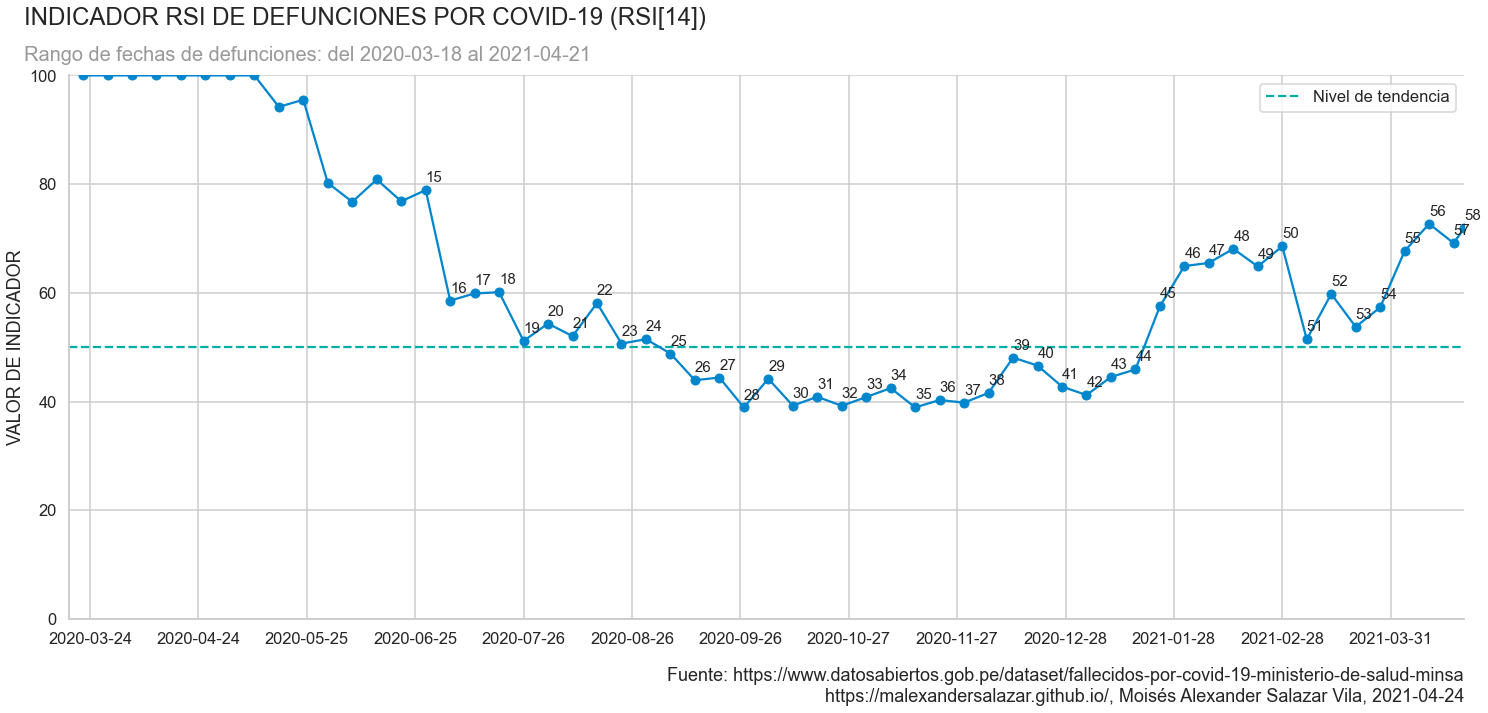

In [27]:
plt.clf()

fig, axs = plt.subplots(figsize=(25,10))
plt.figtext(0.1,0.95, 'INDICADOR RSI DE DEFUNCIONES POR COVID-19 (RSI[14])', ha='left', fontsize=24)
plt.figtext(0.1,0.90, 'Rango de fechas de defunciones: del {} al {}'.format(f'{daily["date"].iat[0]:%Y-%m-%d}',f'{daily["date"].iat[-1]:%Y-%m-%d}'), ha='left', fontsize=20, color='#999')
plt.figtext(0.9,0.01, """Fuente: https://www.datosabiertos.gob.pe/dataset/fallecidos-por-covid-19-ministerio-de-salud-minsa
https://malexandersalazar.github.io/, Moisés Alexander Salazar Vila, """ + f'{DateTime.now():%Y-%m-%d}', ha='right')

formatter = mdates.DateFormatter("%Y-%m-%d")
locator = mdates.DayLocator(interval=31)

axs.xaxis.set_major_formatter(formatter)
axs.xaxis.set_major_locator(locator)

axs.plot(weekly['date'], weekly_rsi, 'o-', color='#0086CD')
axs.hlines(50, daily["date"].iat[0], daily["date"].iat[-1], color='#00AFA6', linestyles= 'dashed', label='Nivel de tendencia')

for i in range(14,len(weekly['date'])):
    axs.text(weekly['date'].iat[i], weekly_rsi.iat[i] + 1.5, str(i+1), fontsize='small')

axs.set_ylim(0,100)
# axs.set_xlim((weekly["date"].iat[PERIOD],daily["date"].iat[-1]))
axs.set_xlim((daily["date"].iat[0],daily["date"].iat[-1]))
axs.set_ylabel('VALOR DE INDICADOR')
axs.legend()

sns.despine(left=False, bottom=False)

filename = 'dist/RSI.png'
plt.savefig("../" + filename, bbox_inches='tight')

plt.show()
plt.close(fig)